In [1]:
import torch, math, numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import uproot as up
# import torch.nn as nn
# from torch.autograd import Function
# from scipy.stats import rel_breitwigner
# from torch import Tensor
# import pandas as pd
# import awkward as ak

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [7]:
file_path = "data/HZZ4l/SMHiggsToZZTo4L.root"
root_file = up.open(file_path)

print("Available keys in the ROOT file:")
for key in root_file.keys():
    print(key)


Available keys in the ROOT file:
Events;1


In [8]:
tree = root_file["Events"]
# tree.keys()  # List all branches in the tree

In [9]:
# Read lepton specific branches:

stop = 10000  # Limit to first 10,000 events for testing
muon_pt     = tree["Muon_pt"].array(library="np", entry_stop=stop)
muon_eta    = tree["Muon_eta"].array(library="np", entry_stop=stop)
muon_phi    = tree["Muon_phi"].array(library="np", entry_stop=stop)
muon_mass   = tree["Muon_mass"].array(library="np", entry_stop=stop)

ele_pt      = tree["Electron_pt"].array(library="np", entry_stop=stop)
ele_eta     = tree["Electron_eta"].array(library="np", entry_stop=stop)
ele_phi     = tree["Electron_phi"].array(library="np", entry_stop=stop)
ele_mass    = tree["Electron_mass"].array(library="np", entry_stop=stop)

n_muons = tree["nMuon"].array(library="np", entry_stop=stop)
n_electrons = tree["nElectron"].array(library="np", entry_stop=stop)

In [10]:
# Total lepton count per event
n_leptons = n_muons + n_electrons

# Boolean mask for events with exactly 4 leptons
mask_4l = n_leptons == 4

# Optional: restrict to 2+2, 4e, or 4mu cases
mask_2e2mu = (n_muons == 2) & (n_electrons == 2)
mask_4mu = n_muons == 4
mask_4e = n_electrons == 4

# Combine all allowed combinations
mask_valid = mask_2e2mu | mask_4mu | mask_4e

# Final mask
mask_final = mask_4l & mask_valid

muon_pt    = muon_pt[mask_final]
muon_eta   = muon_eta[mask_final]
muon_phi   = muon_phi[mask_final]
muon_mass  = muon_mass[mask_final]

ele_pt     = ele_pt[mask_final]
ele_eta    = ele_eta[mask_final]
ele_phi    = ele_phi[mask_final]
ele_mass   = ele_mass[mask_final]

In [11]:
lepton_data = []

for i in range(len(muon_pt)):
    leptons = []

    # Add muons
    for pt, eta, phi, mass in zip(muon_pt[i], muon_eta[i], muon_phi[i], muon_mass[i]):
        leptons.append((pt, eta, phi, mass))

    # Add electrons
    for pt, eta, phi, mass in zip(ele_pt[i], ele_eta[i], ele_phi[i], ele_mass[i]):
        leptons.append((pt, eta, phi, mass))

    # We expect exactly 4 leptons now, but sort to standardize order
    leptons = sorted(leptons, key=lambda x: -x[0])  # sort by pt (desc)

    # Sanity check
    if len(leptons) != 4:
        continue  # Shouldn't happen, but safe fallback

    lepton_data.append(leptons)

print(f"Selected {len(lepton_data)} events with exactly 4 leptons")




Selected 2172 events with exactly 4 leptons


In [12]:
lepton_tensor = torch.tensor(lepton_data, dtype=torch.float32)

In [13]:
def four_vector(pt, eta, phi, mass):
    px = pt * torch.cos(phi)
    py = pt * torch.sin(phi)
    pz = pt * torch.sinh(eta)
    energy = torch.sqrt((pt * torch.cosh(eta))**2 + mass**2)
    return torch.stack((energy, px, py, pz), dim=-1)

def invariant_mass(four_momenta):
    total = torch.sum(four_momenta, dim=1)  # sum over 4 leptons
    E, px, py, pz = total[:, 0], total[:, 1], total[:, 2], total[:, 3]
    mass_squared = E**2 - px**2 - py**2 - pz**2
    return torch.sqrt(torch.clamp(mass_squared, min=0.0))

# Split columns
pt, eta, phi, mass = lepton_tensor[..., 0], lepton_tensor[..., 1], lepton_tensor[..., 2], lepton_tensor[..., 3]

# Compute 4-vectors and mass
four_moms = four_vector(pt, eta, phi, mass)  # [N_events, 4, 4]
masses = invariant_mass(four_moms)           # [N_events]




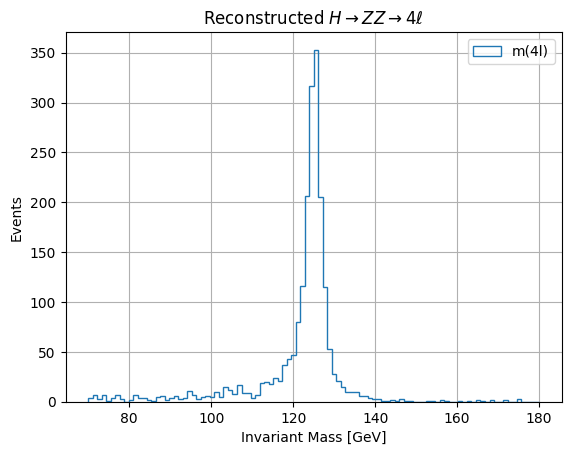

In [14]:
# plt.hist(masses.numpy(), bins=100, range=(70, 180), histtype='step', label=f"m(4l), mean = {masses.mean().item():.1f} GeV")
plt.hist(masses.numpy(), bins=100, histtype='step', label=f"m(4l)", range=(70, 180))
plt.xlabel("Invariant Mass [GeV]")
plt.ylabel("Events")
plt.title("Reconstructed $H \\to ZZ \\to 4\\ell$")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# # --- Constants ---
# M_HIGGS = 125.0  # GeV
# M_Z = 91.1876    # GeV
# G_Z = 2.4952     # GeV
# G_H = 0.00407    # GeV (Higgs width)
# M_LEP = 0.0      # Massless leptons

# # --- Vector Operations ---
# def mass(p4):
#     """Calculate invariant mass from 4-vector"""
#     return torch.sqrt(p4[...,0]**2 - p4[...,1]**2 - p4[...,2]**2 - p4[...,3]**2)

# def boost(p4, beta):
#     """Relativistic boost with safety checks"""
#     beta = beta.clamp(-0.999999, 0.999999)
#     gamma = 1.0 / torch.sqrt(1 - (beta**2).sum(-1, keepdim=True))
#     bp = (p4[..., 1:] * beta).sum(-1, keepdim=True)
#     return torch.cat([
#         gamma * (p4[..., 0:1] - bp),
#         p4[..., 1:] + ((gamma - 1) * bp / (beta**2).sum(-1, keepdim=True)) * beta - gamma * beta * p4[..., 0:1]
#     ], dim=-1)

# # --- Physics Functions ---
# def breit_wigner_transform(uniform_samples, mean, width, min_val=None, max_val=None):
#     """Transform uniform [0,1] samples to (non-relativistic) Breit-Wigner distribution"""
#     gamma = width / 2
#     samples = mean + gamma * torch.tan(math.pi * (uniform_samples - 0.5))
#     if min_val is not None or max_val is not None:
#         samples = samples.clamp(min_val if min_val else -np.inf, 
#                               max_val if max_val else np.inf)
#     return samples

# def two_body_decay(m0, m1, m2):
#     """Safe momentum calculation"""
#     arg = (m0**2 - (m1 + m2)**2) * (m0**2 - (m1 - m2)**2)
#     return torch.sqrt(arg.clamp(min=1e-6)) / (2 * m0)

# def simulate_from_random_numbers(
#     uniform_samples_higgs,    # [batch_size]
#     uniform_samples_z1,       # [batch_size]
#     uniform_samples_z2,       # [batch_size]
#     uniform_angles_higgs,     # [batch_size, 2]
#     uniform_angles_z1,        # [batch_size, 2]
#     uniform_angles_z2,        # [batch_size, 2]
#     higgs_boost_beta=None,    # [batch_size, 3]
#     higgs_width=G_H,
#     z_width=G_Z,
#     device="cpu"
# ):
#     device = torch.device(device)
#     batch_size = uniform_samples_higgs.shape[0]

#     # 1. Sample Higgs mass from narrow Breit-Wigner
#     mH = breit_wigner_transform(
#         uniform_samples_higgs,
#         M_HIGGS,
#         higgs_width,
#         M_HIGGS - 5,
#         M_HIGGS + 5
#     )

#     # 2. Sample mZ1 and mZ2 valid by construction
#     # Basically: f in [0,1] -> mZ1 + mZ2 < mH
#     f = uniform_samples_z2
#     mZ1_raw = breit_wigner_transform(uniform_samples_z1, M_Z, z_width)
#     mZ1 = torch.min(torch.clamp_min(mZ1_raw, 60.0), mH - 30.0)

#     delta = mH - mZ1
#     mZ2 = f * (delta - 1e-3)  # small epsilon to avoid edge

#     # mZ2_raw = breit_wigner_transform(uniform_samples_z2, _mZ2, z_width)
#     # mZ2 = torch.min(torch.clamp_min(mZ2_raw, 60.0), mH - 30.0)

#     # 3. Higgs -> ZZ decay
#     p_mag = two_body_decay(mH, mZ1, mZ2)
#     angles_h = 2 * torch.pi * uniform_angles_higgs
#     theta_h, phi_h = angles_h[:, 0], angles_h[:, 1]

#     sin_th, cos_th = torch.sin(theta_h), torch.cos(theta_h)
#     sin_ph, cos_ph = torch.sin(phi_h), torch.cos(phi_h)

#     px = p_mag * sin_th * cos_ph
#     py = p_mag * sin_th * sin_ph
#     pz = p_mag * cos_th

#     E1 = torch.sqrt(p_mag**2 + mZ1**2)
#     E2 = torch.sqrt(p_mag**2 + mZ2**2)

#     pZ1 = torch.stack([E1, px, py, pz], dim=1)
#     pZ2 = torch.stack([E2, -px, -py, -pz], dim=1)

#     # 4. Z decays to leptons
#     def decay_products(mZ, pZ, angles):
#         decay_p = two_body_decay(mZ, M_LEP, M_LEP)
#         theta = 2 * torch.pi * angles[:, 0]
#         phi = 2 * torch.pi * angles[:, 1]

#         sin_t, cos_t = torch.sin(theta), torch.cos(theta)
#         sin_p, cos_p = torch.sin(phi), torch.cos(phi)

#         px = decay_p * sin_t * cos_p
#         py = decay_p * sin_t * sin_p
#         pz = decay_p * cos_t
#         E = decay_p  # m = 0 -> E = |p|

#         l1 = torch.stack([E, px, py, pz], dim=1)
#         l2 = torch.stack([E, -px, -py, -pz], dim=1)

#         beta = pZ[:, 1:] / pZ[:, 0:1]
#         return boost(l1, beta), boost(l2, beta)

#     l1, l2 = decay_products(mZ1, pZ1, uniform_angles_z1)
#     l3, l4 = decay_products(mZ2, pZ2, uniform_angles_z2)

#     # 5. Boost leptons to lab frame (if applicable)
#     if higgs_boost_beta is not None:
#         l1 = boost(l1, higgs_boost_beta)
#         l2 = boost(l2, higgs_boost_beta)
#         l3 = boost(l3, higgs_boost_beta)
#         l4 = boost(l4, higgs_boost_beta)

#     # 6. Compute observables
#     m4l = mass(l1 + l2 + l3 + l4)
#     mZ1_rec = mass(l1 + l2)
#     mZ2_rec = mass(l3 + l4)

#     return {
#         'm4l': m4l,
#         'mZ1': mZ1,
#         'mZ2': mZ2,
#         'mZ1_rec': mZ1_rec,
#         'mZ2_rec': mZ2_rec
#     }


# def realistic_simulation_from_random_numbers(
#     uniform_samples_higgs,
#     uniform_samples_z1,
#     uniform_samples_z2,
#     uniform_angles_higgs,
#     uniform_angles_z1,
#     uniform_angles_z2,
#     higgs_boost_beta=None,
#     higgs_width=G_H,
#     z_width=G_Z,
#     device="cpu",
#     # New parameters for realism
#     detector_resolution=0.01,  # 1% energy resolution
#     background_fraction=0.2,   # 20% background
#     efficiency_params=(100.0, 5.0)  # Sigmoid cutoff, slope
# ):
#     # Original simulation
#     results = simulate_from_random_numbers(
#         uniform_samples_higgs,
#         uniform_samples_z1,
#         uniform_samples_z2,
#         uniform_angles_higgs,
#         uniform_angles_z1,
#         uniform_angles_z2,
#         higgs_boost_beta,
#         higgs_width,
#         z_width,
#         device
#     )
    
#     batch_size = uniform_samples_higgs.shape[0]
#     device = torch.device(device)
    
#     # 1. Apply detector resolution smearing
#     resolution_factor = 1.0 + detector_resolution * torch.randn(batch_size, device=device)
#     smeared_m4l = results['m4l'] * resolution_factor
    
#     # 2. Add continuum ZZ background
#     is_background = torch.rand(batch_size, device=device) < background_fraction
#     # background_mass = 80.0 + 40.0 * torch.rand(batch_size, device=device)  # Flat 80-120 GeV
#     background_mass = 80.0 + 80.0 * torch.rand(batch_size, device=device)  # Flat 80-160 GeV
#     realistic_m4l = torch.where(is_background, background_mass, smeared_m4l)
    
#     # 3. Apply detector acceptance
#     m_cutoff, m_slope = efficiency_params
#     efficiency = torch.sigmoid((realistic_m4l - m_cutoff)/m_slope)
#     keep_prob = efficiency

#     return {
#         'perfect_m4l': results['m4l'],
#         'realistic_m4l': realistic_m4l,
#         'keep_prob': keep_prob
#     }

In [15]:
def simple_simulation_from_random_numbers(
    uniform_samples_higgs,
    uniform_samples_z1,
    uniform_samples_z2,
    uniform_angles_higgs,
    uniform_angles_z1,
    uniform_angles_z2,
    higgs_boost_beta=None,
    device="cpu"
):
    device = torch.device(device)
    batch_size = uniform_samples_higgs.shape[0]

    def mass(p4):
        return torch.sqrt(p4[...,0]**2 - p4[...,1]**2 - p4[...,2]**2 - p4[...,3]**2)

    def boost(p4, beta):
        beta = beta.clamp(-0.999999, 0.999999)
        gamma = 1.0 / torch.sqrt(1 - (beta**2).sum(-1, keepdim=True))
        bp = (p4[..., 1:] * beta).sum(-1, keepdim=True)
        return torch.cat([
            gamma * (p4[..., 0:1] - bp),
            p4[..., 1:] + ((gamma - 1) * bp / (beta**2).sum(-1, keepdim=True)) * beta - gamma * beta * p4[..., 0:1]
        ], dim=-1)

    def two_body_decay(m0, m1, m2):
        arg = (m0**2 - (m1 + m2)**2) * (m0**2 - (m1 - m2)**2)
        return torch.sqrt(arg.clamp(min=1e-6)) / (2 * m0)

    mH = 115.0 + 20.0 * uniform_samples_higgs
    mZ1 = 60.0 + 10.0 * uniform_samples_z1
    mZ1 = torch.min(mZ1, mH - 30.0)
    mZ2 = torch.min(60.0 + 10.0 * uniform_samples_z2, mH - mZ1 - 1.0)

    p_mag = two_body_decay(mH, mZ1, mZ2)
    angles_h = 2 * torch.pi * uniform_angles_higgs
    theta_h, phi_h = angles_h[:, 0], angles_h[:, 1]
    sin_th, cos_th = torch.sin(theta_h), torch.cos(theta_h)
    sin_ph, cos_ph = torch.sin(phi_h), torch.cos(phi_h)
    px = p_mag * sin_th * cos_ph
    py = p_mag * sin_th * sin_ph
    pz = p_mag * cos_th
    E1 = torch.sqrt(p_mag**2 + mZ1**2)
    E2 = torch.sqrt(p_mag**2 + mZ2**2)
    pZ1 = torch.stack([E1, px, py, pz], dim=1)
    pZ2 = torch.stack([E2, -px, -py, -pz], dim=1)

    def decay_products(mZ, pZ, angles):
        decay_p = two_body_decay(mZ, 0.0, 0.0)
        theta = 2 * torch.pi * angles[:, 0]
        phi = 2 * torch.pi * angles[:, 1]
        sin_t, cos_t = torch.sin(theta), torch.cos(theta)
        sin_p, cos_p = torch.sin(phi), torch.cos(phi)
        px = decay_p * sin_t * cos_p
        py = decay_p * sin_t * sin_p
        pz = decay_p * cos_t
        E = decay_p
        l1 = torch.stack([E, px, py, pz], dim=1)
        l2 = torch.stack([E, -px, -py, -pz], dim=1)
        beta = pZ[:, 1:] / pZ[:, 0:1]
        return boost(l1, beta), boost(l2, beta)

    l1, l2 = decay_products(mZ1, pZ1, uniform_angles_z1)
    l3, l4 = decay_products(mZ2, pZ2, uniform_angles_z2)

    if higgs_boost_beta is not None:
        l1 = boost(l1, higgs_boost_beta)
        l2 = boost(l2, higgs_boost_beta)
        l3 = boost(l3, higgs_boost_beta)
        l4 = boost(l4, higgs_boost_beta)

    m4l = mass(l1 + l2 + l3 + l4)
    mZ1_rec = mass(l1 + l2)
    mZ2_rec = mass(l3 + l4)

    return {
        'm4l': m4l,
        'mZ1': mZ1,
        'mZ2': mZ2,
        'mZ1_rec': mZ1_rec,
        'mZ2_rec': mZ2_rec
    }


In [13]:
# from torch.autograd import Function
# import torch.nn as nn

# class RealisticHiggsSimulationFunction(Function):
#     @staticmethod
#     def forward(ctx, uniform_samples):
#         results = realistic_simulation_from_random_numbers(
#             uniform_samples[:, 0],
#             uniform_samples[:, 1],
#             uniform_samples[:, 2],
#             uniform_samples[:, 3:5],
#             uniform_samples[:, 5:7],
#             uniform_samples[:, 5:7],  # Reuse
#             device=uniform_samples.device
#         )

#         ctx.save_for_backward(uniform_samples, results['keep_prob'])
#         return results['realistic_m4l'], results['keep_prob']  # keep all


#     @staticmethod
#     def backward(ctx, grad_output, grad_keep_prob):
#         uniform_samples, keep_prob = ctx.saved_tensors  # input: [batch_size, 7]
#         batch_size, latent_dim = uniform_samples.shape

#         # grad_output: [batch_size, 1]
#         # keep_prob: [batch_size]

#         # Reshape weights and expand to match input shape
#         weight = keep_prob.view(-1, 1)  # [batch_size, 1]
#         grad_output = grad_output.view(-1, 1)  # [batch_size, 1]

#         grad_input = grad_output * weight  # [batch_size, 1]
#         grad_input = grad_input.expand(-1, latent_dim)  # [batch_size, latent_dim]

#         return grad_input


# class HiggsSimulationLayer(nn.Module):
#     def forward(self, uniform_samples):
#         """
#         Args:
#             uniform_samples: Tensor of shape [batch_size, 7] (U[0,1] samples)
#         Returns:
#             m4l: Tensor of shape [batch_size, 1]
#         """
#         # return HiggsSimulationFunction.apply(uniform_samples)
#         return RealisticHiggsSimulationFunction.apply(uniform_samples)


In [16]:
from torch.autograd import Function
import torch.nn as nn

# -- Register this function first --
class SimpleHiggsSimulationFunction(Function):
    @staticmethod
    def forward(ctx, uniform_samples):
        results = simple_simulation_from_random_numbers(
            uniform_samples[:, 0],
            uniform_samples[:, 1],
            uniform_samples[:, 2],
            uniform_samples[:, 3:5],
            uniform_samples[:, 5:7],
            uniform_samples[:, 5:7],  # reused
            device=uniform_samples.device
        )

        ctx.save_for_backward(uniform_samples)
        return results['m4l'].view(-1, 1), torch.ones_like(results['m4l'].view(-1, 1))  # dummy keep_prob just to not change the KL loss code later...

    @staticmethod
    def backward(ctx, grad_output, grad_dummy):
        uniform_samples, = ctx.saved_tensors
        batch_size, latent_dim = uniform_samples.shape

        # Simple uniform gradient to flow through inputs
        grad_input = grad_output.expand(-1, latent_dim)
        return grad_input


# -- Drop-in Module Layer --
class HiggsSimulationLayer(nn.Module):
    def forward(self, uniform_samples):
        """
        Args:
            uniform_samples: Tensor of shape [batch_size, 7] (U[0,1] samples)
        Returns:
            m4l: Tensor of shape [batch_size, 1]
        """
        return SimpleHiggsSimulationFunction.apply(uniform_samples)



In [17]:
def plot_comparison(simulated_m4l, real_masses, epoch):
    """Helper function for visualization"""
    plt.figure(figsize=(12, 4))
    
    # Plot distributions
    plt.subplot(121)
    plt.hist(simulated_m4l.cpu().numpy(), bins=50, range=(100, 150),
             alpha=0.5, label=f'Simulated (Epoch {epoch})')
    plt.xlabel("m4l [GeV]")
    plt.ylabel("Events")
    plt.legend()
    
    # Plot overlay with data
    plt.subplot(122)
    plt.hist(simulated_m4l.cpu().numpy(), bins=50, range=(100, 150),
             alpha=0.5, label='Simulated')
    plt.hist(real_masses.numpy(), bins=50, range=(100, 150),
             histtype='step', linewidth=2, label='Real Data')
    plt.xlabel("m4l [GeV]")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [36]:
def kl_histogram_loss(
    m4l_simulated,
    m4l_data,
    weights=None,
    num_bins=50,
    mass_range=(105.0, 140.0),
    temperature=0.2
):
    """
    Differentiable KL divergence between weighted histograms using soft binning.

    Args:
        m4l_simulated: Tensor [N_sim, 1] — simulated values
        m4l_data: Tensor [N_data, 1] — real observed values
        weights: Tensor [N_sim] — weights for simulated values (e.g., efficiency)
        num_bins: histogram bins
        mass_range: (min, max) bounds for mass
        temperature: softness of binning
    Returns:
        Scalar KL divergence (differentiable)
    """
    device = m4l_simulated.device

    # --- Bin Setup ---
    bin_edges = torch.linspace(*mass_range, num_bins + 1, device=device)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # [num_bins]
    centers = bin_centers.view(1, -1)  # [1, B]

    # --- Soft Bin Assignment ---
    def get_soft_counts(values, weights=None):
        values = values.view(-1, 1)  # [N, 1]
        distances = (values - centers) / temperature  # [N, B]
        soft_assignments = torch.exp(-0.5 * distances ** 2)  # Gaussian kernel

        if weights is not None:
            weights = weights.view(-1, 1)  # [N, 1]

            # Optional: Clamp weights to prevent extreme influence
            weights = torch.clamp(weights, min=1e-3, max=10.0)

            # Normalize weights (optional but helps)
            weights = weights / (weights.sum() + 1e-8)

            soft_assignments = soft_assignments * weights  # [N, B]

        return soft_assignments.sum(dim=0)  # [B]

    # --- Compute Soft Histograms ---
    eps = 1e-8
    sim_hist = get_soft_counts(m4l_simulated, weights) + eps
    data_hist = get_soft_counts(m4l_data) + eps

    # Normalize to PDFs
    sim_pdf = sim_hist / sim_hist.sum()
    data_pdf = data_hist / data_hist.sum()

    # --- KL Divergence ---
    kl = (data_pdf * (torch.log(data_pdf) - torch.log(sim_pdf))).sum()

    # Optional safeguard (in case of numerical anomalies)
    if torch.isnan(kl) or torch.isinf(kl):
        kl = torch.tensor(0.0, device=device, requires_grad=True)
    
    lambda_edge = 0.3  # Penalty for edge bins
    edge_bins = list(range(3)) + list(range(-3, 0))
    penalty = sim_pdf[edge_bins].sum()
    loss = kl + lambda_edge * penalty
    return loss



In [37]:
# ------------------------------------------------------------------
# Hyper-parameters
# ------------------------------------------------------------------
n_in        = 7       # number of parameters, i.e., random numbers needed in the simulation
n_hidden    = 12      # number of hidden neurons in the network, at each layer
n_layers    = 3       # number of hidden layers in the network
n_out       = n_in    # must match the number of output parameters
batch_size  = 2_000   # samples of random number per batch, to build the distribution. Larger is better, but slower
epochs      = 10_000   # number of epochs to train the network
lr          = 1e-3    # learning rate for the optimizer

In [38]:
# ------------------------------------------------------------------
# MLP producing seeds in [0,1]^7
# ------------------------------------------------------------------
def make_mlp(n_in, n_hidden, n_layers, n_out):
    layers, d = [], n_in
    for _ in range(n_layers):
        layers += [nn.Linear(d, n_hidden), nn.ReLU()]
        d = n_hidden
    layers += [nn.Linear(d, n_out), nn.Sigmoid()]
    return nn.Sequential(*layers)

net       = make_mlp(n_in, n_hidden, n_layers, n_out).to(device)
f_layer   = HiggsSimulationLayer()
optimiser = optim.Adam(net.parameters(), lr=lr)

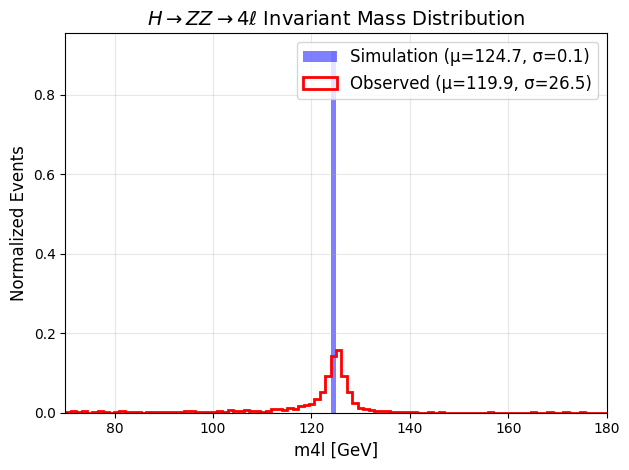

Epoch 100: Loss = 2.6196)
Epoch 200: Loss = 1.3383)
Epoch 300: Loss = 0.9514)
Epoch 400: Loss = 0.9851)
Epoch 500: Loss = 0.9831)
Epoch 600: Loss = 0.7029)
Epoch 700: Loss = 0.7929)
Epoch 800: Loss = 0.7568)
Epoch 900: Loss = 0.7724)
Epoch 1000: Loss = 0.9305)
Epoch 1100: Loss = 0.7681)
Epoch 1200: Loss = 0.7385)
Epoch 1300: Loss = 0.8478)
Epoch 1400: Loss = 0.6377)
Epoch 1500: Loss = 0.7986)
Epoch 1600: Loss = 0.7697)
Epoch 1700: Loss = 0.7830)
Epoch 1800: Loss = 0.8809)
Epoch 1900: Loss = 0.6753)
Epoch 2000: Loss = 0.8943)
Epoch 2100: Loss = 0.7860)
Epoch 2200: Loss = 0.8765)
Epoch 2300: Loss = 0.6167)
Epoch 2400: Loss = 0.7309)
Epoch 2500: Loss = 0.7188)
Epoch 2600: Loss = 0.7884)
Epoch 2700: Loss = 0.5433)
Epoch 2800: Loss = 0.9132)
Epoch 2900: Loss = 0.7180)
Epoch 3000: Loss = 0.7076)
Epoch 3100: Loss = 0.6825)
Epoch 3200: Loss = 0.8075)
Epoch 3300: Loss = 0.6601)
Epoch 3400: Loss = 0.6906)
Epoch 3500: Loss = 0.7441)
Epoch 3600: Loss = 0.8150)
Epoch 3700: Loss = 0.7066)
Epoch 3800

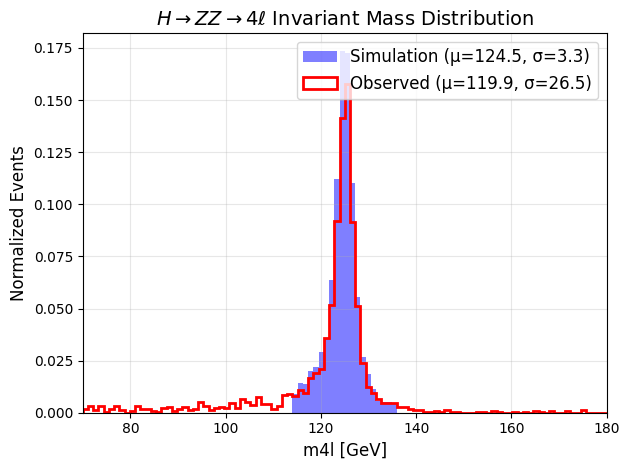

Epoch 5100: Loss = 0.7028)
Epoch 5200: Loss = 0.7707)
Epoch 5300: Loss = 0.7473)
Epoch 5400: Loss = 0.6628)
Epoch 5500: Loss = 0.7313)
Epoch 5600: Loss = 0.8130)
Epoch 5700: Loss = 0.7587)
Epoch 5800: Loss = 0.7602)
Epoch 5900: Loss = 0.7260)
Epoch 6000: Loss = 0.6274)
Epoch 6100: Loss = 0.7083)
Epoch 6200: Loss = 0.6858)
Epoch 6300: Loss = 0.7959)
Epoch 6400: Loss = 0.8497)
Epoch 6500: Loss = 0.6396)
Epoch 6600: Loss = 0.8348)
Epoch 6700: Loss = 0.6422)
Epoch 6800: Loss = 0.7294)
Epoch 6900: Loss = 0.7047)
Epoch 7000: Loss = 0.7507)
Epoch 7100: Loss = 0.6842)
Epoch 7200: Loss = 0.7168)
Epoch 7300: Loss = 0.5468)
Epoch 7400: Loss = 0.6429)
Epoch 7500: Loss = 0.6888)
Epoch 7600: Loss = 0.8931)
Epoch 7700: Loss = 0.7433)
Epoch 7800: Loss = 0.7976)
Epoch 7900: Loss = 0.7533)
Epoch 8000: Loss = 0.8529)
Epoch 8100: Loss = 0.8027)
Epoch 8200: Loss = 0.6996)
Epoch 8300: Loss = 0.6546)
Epoch 8400: Loss = 0.8477)
Epoch 8500: Loss = 0.7807)
Epoch 8600: Loss = 0.6705)
Epoch 8700: Loss = 0.6855)
E

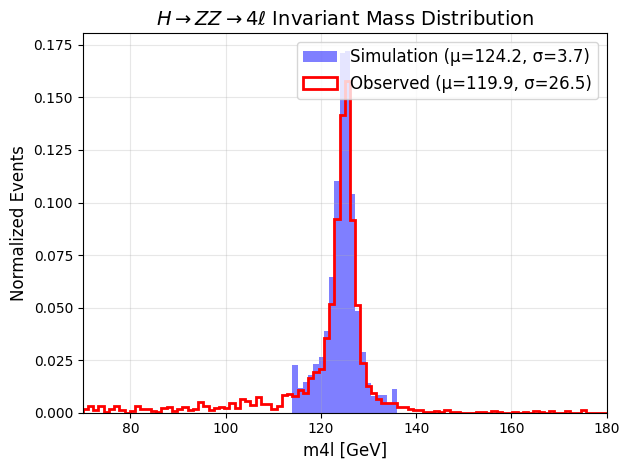

In [39]:
batch_size = 2000
plot_every = 5000
masses = masses.to(device)  # Ensure masses are on the correct device
net.train()

for epoch in range(1, epochs + 1):
    # 1. Generate inputs
    x = (2.0 * torch.rand(batch_size, n_in, device=device) - 1.0)
    
    # 2. Forward pass
    t = net(x)
    y, efficiencies = f_layer(t)
    # y = f_layer(t)
    
    # 3. Handle variable batch size -> because realistic simulation may not keep all events
    #    (e.g., due to efficiency, background, etc.)
    current_batch_size = y.size(0)
    if current_batch_size == 0:
        print("Warning: No events passed cuts!")
        continue
        
    # 4. Compute loss with matching real data
    loss_masses = masses[torch.randint(0, len(masses), (current_batch_size,))]
    # kl_loss = kl_histogram_loss(y, loss_masses)
    kl_loss = kl_histogram_loss(y, loss_masses, weights=efficiencies)
    
    # 5. Backward pass
    optimiser.zero_grad()
    kl_loss.backward()
    optimiser.step()
    
    # 6. Logging and visualization
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {kl_loss.item():.4f})")#, "
            #   f"Kept {current_batch_size}/{batch_size} events")
        
    if epoch % plot_every == 0 or epoch == 1:
        with torch.no_grad():
            viz_samples = stop
            x_viz = (2.0 * torch.rand(viz_samples, n_in, device=device) - 1.0)
            y_viz = f_layer(net(x_viz))[0]  # Get only m4l
            mean_sim = y.mean()
            std_sim = y.std()
            mean_data = masses.mean()
            std_data = masses.std()
            
            plt.hist(y_viz.cpu(), bins=100, range=(70, 180), density=True, 
                     alpha=0.5, color='blue', label=f'Simulation (μ={mean_sim:.1f}, σ={std_sim:.1f})')
            plt.hist(masses.numpy(), bins=100, range=(70, 180), density=True,
                    histtype='step', linewidth=2, color='red', label=f'Observed (μ={mean_data:.1f}, σ={std_data:.1f})')
            plt.xlabel("m4l [GeV]", fontsize=12)
            plt.ylabel("Normalized Events", fontsize=12)
            plt.title("$H \\to ZZ \\to 4\\ell$ Invariant Mass Distribution", fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.xlim(70, 180)

            # Add ratio plot below
            plt.tight_layout()
            plt.show()

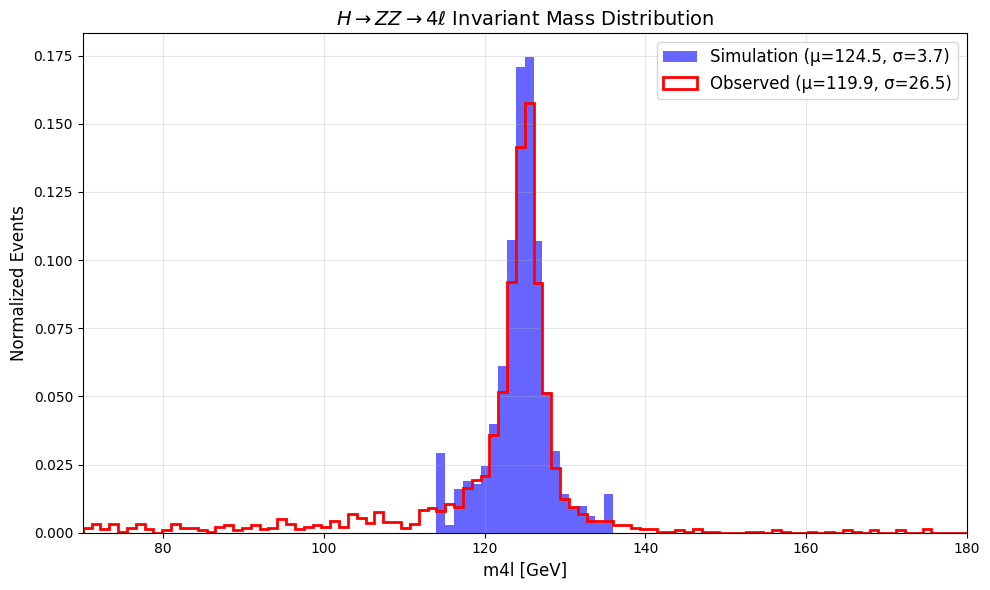

In [23]:
# Evaluation mode (affects dropout, batch norm etc.)
net.eval()  

with torch.no_grad():
    # Generate multiple batches for better statistics
    num_test_samples = 10000
    x = (2.0 * torch.rand(num_test_samples, n_in, device=device) - 1.0)
    t = net(x)
    y = f_layer(t)[0]  # Flatten to 1D array
    
    # Calculate basic statistics
    mean_sim = y.mean()
    std_sim = y.std()
    mean_data = masses.mean()
    std_data = masses.std()

# Create figure
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(y.cpu(), bins=100, range=(70, 180), density=True, 
         alpha=0.6, color='blue', label=f'Simulation (μ={mean_sim:.1f}, σ={std_sim:.1f})')

plt.hist(masses.numpy(), bins=100, range=(70, 180), density=True,
         histtype='step', linewidth=2, color='red', 
         label=f'Observed (μ={mean_data:.1f}, σ={std_data:.1f})')

# Formatting
plt.xlabel("m4l [GeV]", fontsize=12)
plt.ylabel("Normalized Events", fontsize=12)
plt.title("$H \\to ZZ \\to 4\\ell$ Invariant Mass Distribution", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(70, 180)

# Add ratio plot below
plt.tight_layout()
plt.show()

# # Print KS test results
# from scipy import stats
# ks_stat, p_value = stats.ks_2samp(y.numpy(), masses.numpy())
# print(f"\nKS Test: D={ks_stat:.3f}, p-value={p_value:.3f}")
# print(f"Mean difference: {(mean_sim-mean_data):.2f} GeV")
# print(f"Std deviation ratio: {(std_sim/std_data):.2f}")